In [ ]:
using CausalityTools
include("../entropy.jl")
using Random
using BenchmarkTools

rng = MersenneTwister(145)

a = rand(rng, 0:10, 100)
b = rand(rng, 0:10, 100)

est = Kraskov(k=1)

print("Current method :")
foo = @btime TE(Int.(a .> 0), Int.(b .> 0))
println("The result is $foo.\n")


print("True transfer entropy :")
a = float.(a)
b = float.(b)
foo2 = @btime transferentropy(a, b, est)
println("The result is $foo2.\n")

print("CCM :")
foo3 = @btime crossmap(a, b, 2, 1)
println("The result is $foo3.\n")

In [ ]:
using StatsBase

a = [1 1 1 1 0 0]
b = [1 1 0 0 0 1]

countmap(a)

In [ ]:
foo = [(a[i+1], a[i], b[i]) for i = 1:(length(a)-1)]


In [ ]:
proportionmap(foo) 

In [ ]:
include("../Utils/entropy.jl")


function transfer_entropy(X, Y)

    N = length(X)
    # configurations = [(Y[i+1], Y[i], X[i]) for i = 1:(N-1)]
    configurations = [(Y[i], Y[i-1], X[i-1]) for i = 2:N]
    states = proportionmap(configurations)

    tot = 0

    for state in keys(states)
        state_proba = states[state]
        # P_Yn_Xn = sum((Y .== state[2]) .& (X .== state[3])) / N
        # P_Yn1_Yn = sum((Y[2:end] .== state[1]) .& (Y[1:(end-1)] .== state[2])) / (N - 1)
        P_Yn_Xn = sum((Y[2:end] .== state[2]) .& (X[2:end] .== state[3])) / (N-1)
        P_Yn1_Yn = sum((Y[2:end] .== state[1]) .& (Y[1:(end-1)] .== state[2])) / (N - 1)
        # P_Yn = sum(Y .== state[2]) / N
        P_Yn = sum(Y[2:end] .== state[2]) / (N-1)

        numerator = state_proba / P_Yn_Xn
        denominator = P_Yn1_Yn / P_Yn

        tot += state_proba * log(numerator / denominator)

    end

    return tot

end


# a = [1 1 1 1 0 0]
# b = [1 1 0 0 0 1]

# a = rand(0:1, 100)
# b = rand(0:1, 100)

println("TE : $(TE(a,b))")
println("new : $(transfer_entropy(a,b))")

In [ ]:
X, Y = a, b
configurations = [(Y[i], Y[i-1], X[i-1]) for i = 2:length(X)]
states = proportionmap(configurations)

In [ ]:
using CausalityTools
using StatsBase

func(x,y) = pvalue(jdd(OneSampleTTest, x, y, B=10, D=5, τ=1, μ0=0.0), tail=:right)

a = Vector{Int}(undef, 100)
b = Vector{Int}(undef, 100)

a[1:2:end] .= 0
a[2:2:end] .= 1
a[end-10:end] .= 2

b[1:2:end] .= 1
b[2:2:end] .= 0
b[end-10:end] .= 4

a = (a .- mean(a)) / std(a)
a = (b .- mean(b)) / std(b)

a = rand(0:3, 100)
b = rand(0:3, 100)

func(a,b)

In [ ]:
using Dates
# using Revise
import PlotlyJS

include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;

datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)

data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");

In [ ]:
data.time_bin .= 0

In [ ]:
show(data[:, [3, 4, 5,6]])

In [ ]:
import PyPlot as plt

rng = MersenneTwister(145)

a = rand(rng, 0:10, 100)
b = rand(rng, 0:10, 100)

a = float.(a)
b = float.(b)

Ls = [10:5:50; 60:10:100]

@btime begin
    test = [crossmap(a[1:L], b[1:L], 2, 1) for L in Ls]
    test2 = [crossmap(b[1:L], a[1:L], 2, 1) for L in Ls]
end

plt.figure()
plt.plot(Ls, test, "b-", label="a to b")
plt.plot(Ls, test2, "r-", label="b to a")
plt.legend()
show(plt.gcf())

In [ ]:
using CausalityTools

s_measure()

In [ ]:
using CausalityTools

# A two-dimensional Ulam lattice map
sys = ulam(2)

# Sample 1000 points after discarding 5000 transients
orbit = trajectory(sys, 1000, Ttr = 5000)
x, y = orbit[:, 1], orbit[:, 2]

# 4-dimensional embedding for `x`, 5-dimensional embedding for `y`
s_measure(x, y, dx = 4, τx = 3, dy = 5, τy = 1)

In [ ]:
using DelayEmbeddings

a = collect(1:100)
p = embed(a, 2, 5)

In [ ]:
using Neighborhood

a = [0, 1.2, 0.1, 0.8]
b = [0, 0, 1.8, 0.8]


X = embed(a, 2, 1)
Y = embed(b, 2, 1)

treeX = searchstructure(KDTree, X, Euclidean())
treeY = searchstructure(KDTree, Y, Euclidean())
neighborhoodtype, theiler = NeighborNumber(1), Theiler(0)
idxs_X = bulkisearch(treeX, X, neighborhoodtype, theiler)
idxs_Y = bulkisearch(treeY, Y, neighborhoodtype, theiler)

print(idxs_Y)

In [ ]:
using CausalityTools
using BenchmarkTools

include("../Utils/entropy.jl")

x = rand(0:10, 50)
y = rand(0:10, 50)

@btime s_measure(float(x), float(y), K=3, dx=5, dy=5, τx=1, τy=1)

@btime TE(Int.(x .> 0), Int.(y .> 0))

In [ ]:
using HypothesisTests

x = rand(0:10, 50)
y = rand(0:10, 50)

@btime jdd(OneSampleTTest, x, y, B=10, D=2, τ=1)

In [ ]:
source = collect(1:5)
target = collect(11:15)

D = 2
B = 10
τs = 1

@btime Ex = DelayEmbeddings.embed(source, D, τs)
Ey = DelayEmbeddings.embed(target, D, τs)
Mx = DelayEmbeddings.Matrix(Ex)
My = DelayEmbeddings.Matrix(Ey)

In [ ]:
import DelayEmbeddings

source = collect(1:5)
target = collect(11:15)

D = 2
B = 10
τ = 1

js = ([1 for i = 1:D]...,)
τs = (collect(0:-τ:-(D-1)*τ)...,)

Ex = DelayEmbeddings.genembed(source, τs, js)
Ey = DelayEmbeddings.genembed(target, τs, js)
Mx = DelayEmbeddings.Matrix(Ex)
My = DelayEmbeddings.Matrix(Ey)

In [ ]:
Matrix(Ex) 

In [ ]:
foo = [0 1; 2 0]
LinearIndices(foo[foo .> 0])

In [ ]:
My

In [ ]:
Mx

In [ ]:
using Distances

pairwise(Euclidean(), Mx, Mx, dims=1)

In [ ]:
Euclidean()([2,1], [3,2])

In [ ]:
using BenchmarkTools
using CausalityTools

include("../Utils/entropy.jl")

B = 10
d = 3
τ = 1
alpha = 0.001

K = 3
dx = 3
dy = 3
τx = 1
τy = 1

cuttoff = 0.5
cuttoff2 = 0.01

func1(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0
func2(x, y) = TE(Int.(x .> 0), Int.(y .> 0)) > cuttoff ? 1 : 0
func3(x,y) = s_measure(float(x), float(y), K=K, dx=dx, dy=dy, τx=τx, τy=τy) > cuttoff2 ? 1 : 0

tot1 = 0
tot2 = 0
tot3 = 0
nans = 0
for i = 1:100
    x = rand(0:10, 30)
    y = rand(0:10, 30)

    tot1 += func1(x ,y)
    tot2 += func2(x ,y)
    tot3 += func3(x ,y)
end

println("jdd : $tot1")
println("TE : $tot2")
println("s measure : $tot3")

In [ ]:
using BenchmarkTools
using CausalityTools
using StatsBase: minimum, maximum, mean, std

function standardize(x)
    std_ = std(x, dims=1)
    return (x .- mean(x, dims=1)) ./ ifelse.(std_ .> 0, std_, ones(size(std_)))
end

B = 10
d = 3
τ = 1
alpha = 0.001

cuttoff = 0.5
cuttoff2 = 0.01

Nts = 13*24*2

func(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0

tot = 0

for i = 1:10000
    x = standardize(rand(0:10, Nts))
    y = standardize(rand(0:10, Nts))

    # x = rand(0:10, Nts)
    # y = rand(0:10, Nts)

    tot += func(x ,y)
end

println("jdd : $tot")

In [ ]:
using Dates
# using Revise
import PlotlyJS

include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;


In [ ]:
a = TimeSeriesGenerator(Minute(12), standardize=true)

In [ ]:
using BenchmarkTools
using CausalityTools
using StatsBase

function normalize(x)
    return (x .- mean(x))/std(x)
end


B = 10
d = 3
τ = 1
alpha = 0.001

Nsurr = 50
p_value_surr = Vector{Float64}(undef, Nsurr)

func(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right)

tot = 0
eviter = 0

for i = 1:1000
    x = rand(0:10, 100)
    y = rand(0:10, 100)

    p = func(x, y)

    if p < alpha

        s = surrogenerator(x, RandomShuffle())

        for i = 1:Nsurr
            p_value_surr[i] = func(s(), y)
            # p_value_surr[i] = func(rand(0:10, 100), y)
        end

        limit = quantile(p_value_surr, 0.01)/4
        limit2 = minimum()

        if p < limit
            tot += 1
            println("p : $p    limit: $limit     limit2: $(limit2)")

        else
            eviter += 1
        end

    end

    #= if p < alpha
        tot += 1
    end =#

end

println("jdd : $tot")
println("We removed : $eviter")

In [ ]:
println(quantile(p_value_surr, 0.01)/4)
println(quantile(p_value_surr, 0.05)/4)
confint(OneSampleTTest(p_value_surr), 0.0001)

In [ ]:
x = 1:100
y = 101:200

p = func(x, y)

if p < alpha

    s = surrogenerator(x, RandomShuffle())

    for i = 1:Nsurr
        p_value_surr[i] = func(s(), y)
        # p_value_surr[i] = func(rand(0:10, 100), y)
    end

    limit = minimum(p_value_surr)/2 #quantile(p_value_surr, 0.05)

    println("p : $p    limit: $limit")

    if p < limit
        tot += 1
    end

end

In [ ]:
import PyPlot as plt
using Distributions

foo = fit_mle(Normal, p_value_surr)


show(plt.hist(p_value_surr, bins=20))
plt.plot(0:0.001:0.3, rand(foo, length(0:0.001:0.3)), "-r")
foo

In [ ]:
float.(p_value_surr)

In [ ]:
d = Normal()
x = rand(d, 100)



In [ ]:
using CausalityTools

a = float([1, 2, 3, [0 for i = 1:99]...])

est = VisitationFrequency(RectangularBinning(2.))
# est = NaiveKernel(1.8)
# est = SymbolicPermutation()
probabilities(a, est)

In [ ]:
using CausalityTools

a = float([1 for i = 1:100])
b = float([1 for i = 1:100])

# est = Kraskov(k=3)
est = VisitationFrequency(RectangularBinning(10))
# est = NaiveKernel(1.8)
# est = SymbolicPermutation()
# probabilities(a, est)
transferentropy(a, b, est)

In [ ]:
include("../Utils/entropy.jl")
using StatsBase: mean

foo = []
for i = 1:10000
    a = rand(0:1, 26)
    b = rand(0:1, 26)

    push!(foo, TE(a, b))
end

maximum(foo)

In [ ]:
sum(foo .> 0.5)

In [ ]:
using CausalityTools

a = collect(1:30)
b = collect(51:80)

a = [[0 for i in 1:30]..., a...]
b = [[0 for i in 1:30]..., b...]

B = 10
d = 3
τ = 5
alpha = 0.001

func(x,y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right)
func(a, b)

In [ ]:
func2(x, y) = TE(Int.(x .> 0), Int.(y .> 0))

nans = 0
for i = 1:100
    x = rand(0:10, 100)
    y = rand(0:10, 100)

    isnan(func2(x,y)) ? nans += 1 : nans += 0
end

nans

In [ ]:
x = rand(0:10, 30)
y = rand(0:10, 30)

B = 10
d = 3
τ = 1
alpha = 0.001

func1(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=B, D=d, τ=τ, μ0=0.0), tail=:right) < alpha ? 1 : 0
@btime func1(x,y)

In [ ]:
foo = zeros(3,3)
try
    a = minimum(foo[foo .> 0])
catch
    print("foo")
end

In [ ]:
est = VisitationFrequency(RectangularBinning(10))

n = 1000
# Source and target variables
s, t = rand(n), rand(n)


est = NaiveKernel(0.3)
@btime bbnue(s, t, est)

In [ ]:
using CausalityTools

a = float([[0 for i = 1:24]..., 1, [0 for i = 1:75]...])
b = float([[0 for i = 1:36]..., 1, [0 for i = 1:63]...])

a = (a .- mean(a)) / std(a)
b = (b .- mean(b)) / std(b)

transferentropy(a, b, Kraskov(k=3))

In [ ]:
using Dates

start_time = DateTime(2021, 10, 11, 13, 23, 12) 
end_time = DateTime(2021, 10, 28, 23, 29, 13) 
time_interval = Day(1)

println(floor(start_time, time_interval))
println(ceil(end_time, time_interval))

In [ ]:
start_time = DateTime(2021, 10, 11, 13, 23, 12) 
end_time = DateTime(2021, 10, 28, 23, 29, 13) 
time_interval = Day(1)

function create_time_intervals(start_time::DateTime, end_time::DateTime, time_interval::Period)

    # Set beginning and end of interval by rounding
    start_time = floor(start_time, time_interval)
    end_time = ceil(end_time, time_interval)

    intervals = [start_time]
    
    if end_time - start_time > time_interval
        start = start_time
        while start + time_interval < end_time
            push!(intervals, start + time_interval)
            start += time_interval
        end
    end
            
    push!(intervals, end_time)
    
    return intervals


end

create_time_intervals(start_time, end_time, time_interval)

start_time

In [ ]:
Minute <: Period

In [ ]:
using DataFrames
using Dates
include("../Utils/Helpers.jl")
using .Helpers

datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)

data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");

In [ ]:
start_time = minimum(data.created_at)
println(start_time)
println(floor(start_time, Minute))

In [ ]:
end_time = maximum(data.created_at)
println(end_time)
println(ceil(end_time, Minute))

In [ ]:

start_time = minimum(data.created_at)
end_time = maximum(data.created_at)
time_interval = Hour(5)

function create_time_intervals(start_time::DateTime, end_time::DateTime, time_interval::Period)

    # Set beginning and end of interval by rounding
    start_time = floor(start_time, Minute)
    end_time = ceil(end_time, Minute)

    intervals = [start_time]
    
    if end_time - start_time > time_interval
        start = start_time
        while start + time_interval < end_time
            push!(intervals, start + time_interval)
            start += time_interval
        end
    end
            
    push!(intervals, end_time)
    
    return intervals


end

foo = create_time_intervals(start_time, end_time, time_interval)

In [ ]:
length(foo) - 1

In [ ]:
total_min = 5*60

clean_dates = x -> floor(x, Dates.Minute(total_min))
data.time = clean_dates.(data."created_at")

In [ ]:
a = Vector{Int}(undef, 2)

In [ ]:
isassigned(a, 3)

In [ ]:
using DataFrames
using Dates
include("../Utils/Helpers.jl")
using .Helpers
include("../Sensors/Sensors.jl")
import .Sensors as sen

datafolder = "../../Data/Twitter/COP26_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...)

data = data[.~ismissing.(data."domain"), :]

to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
data."created_at" = to_datetime.(data."created_at");



In [ ]:
foo = x -> floor(x, Minute)
time = foo.(data.created_at)

In [ ]:
println(length(unique(time)))
println(24*60*39)


In [ ]:
13*24/2

In [ ]:
5 ÷ 2

In [ ]:
isodd(3)

In [ ]:
include("../Sensors/Sensors.jl")
include("../Utils/Visualizations.jl")
using .Visualizations;
import PyPlot as plt

Nbar = 1
x_length = 6
width = 0.5
spacing = 0.2

Y = rand(Nbar, x_length)
X, ticks = Visualizations.barplot_layout(Nbar, x_length, width=width, spacing=spacing)

plt.figure()
for i = 1:Nbar
    plt.bar(X[i, :], Y[i, :], width=width, label="$i", zorder=2)
end
plt.xticks(ticks)
show(plt.gcf())

In [ ]:
x = rand(4)
[x... [0. for i = 1:3]...]

In [ ]:
using Revise
include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;

a = [0.1 0.2;0.05 0.2]
b = [0.8 0.2;0.6 0.1]
c = [0.1 0.2;0.2 0]
d = [0.9 0.2;0.6 0.7]
e = [0 0;0 0]

B = SingleInfluenceGraph(undef, 3, 3)

B[1,1] = e
B[1,2] = b
B[1,3] = e
B[2,1] = e
B[2,2] = e
B[2,3] = d
B[3,1] = e
B[3,2] = e
B[3,3] = e

cuttoff = 0.5
icg = InfluenceCascadeGenerator(cuttoff, false)

cascades_A = observe(B, icg)

In [ ]:
B

In [ ]:
include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;

f = [1.2 0.3 0.; 0.7 0.3 0.3; 0. 0.6 0.]
g = [0.3 0.3 0.3; 0.2 0.9 0.8; 0.3 0.9 0.]
h = zeros(3,3)

C = SingleInfluenceGraph(undef, 4, 4)

for i in 1:size(C,1), j in 1:size(C,2)
    C[i,j] = h
end

C[1, 4] = f
C[2,1] = g
C[3,4] = f
C[4,1] = g

D = SingleInfluenceGraph(undef, 4, 4)

for i in 1:size(C,1), j in 1:size(C,2)
    D[i,j] = h
end

D[1, 2] = f
D[1, 4] = f
D[2,3] = g
D[3,2] = f
D[4,2] = g

cuttoff = 0.5
icg = InfluenceCascadeGenerator(cuttoff, false)

cascades = observe(D, icg)
println(cascades[1].actor_edges)
println(cascades[1].actors_per_level)

In [ ]:
println(cascades[2].actor_edges)
println(cascades[2].actors_per_level)

In [ ]:
using DataStructures

a = Queue{Int}()

enqueue!(a, 2)
enqueue!(a, 2)
a

In [ ]:
foo = dequeue!(a)

In [ ]:
import Random

rng = Random.Xoshiro(123)

a = rand(rng, 10, 10)
b = rand(rng, 10, 10)

In [ ]:
rng1 = Random.Xoshiro(123)

a1 = rand(rng1, 10, 10)
b1 = rand(rng1, 10, 10)

In [ ]:
b == b1

In [ ]:
include("../Sensors/Sensors.jl")
using .Sensors;
import Random

rng1 = Random.Xoshiro(123)
a = rand(rng1, 10)
b = rand(rng1, 10)

foo = InfluenceGraphGenerator(JointDistanceDistribution, alpha=0.001)

foo.causal_function(a, b)

In [ ]:
include("../Sensors/Sensors.jl")
using .Sensors;
import Random

rng1 = Random.Xoshiro(123)
a = rand(rng1, 10)
b = rand(rng1, 10)

foo = InfluenceGraphGenerator(JointDistanceDistribution, alpha=0.001)

foo.causal_function(a, b)

In [ ]:
rng1 = Random.Xoshiro(123)
a = rand(rng1, 10)
b = rand(rng1, 10)

foo = InfluenceGraphGenerator(JointDistanceDistribution, alpha=0.001)

foo.causal_function(a, b)

In [ ]:
rng1 = Random.Xoshiro(123)
a = rand(rng1, 10)
b = rand(rng1, 10)

foo = InfluenceGraphGenerator(JointDistanceDistribution, alpha=0.001)


foo.causal_function(a, b)

In [ ]:
a = SingleInfluenceGraph(undef, 2, 2)
foo1 = [ 1 2; 3 4]
foo2_ = [0.1 0.3; 2.1 3.1]
foo3 = [0 0; 2 1]
foo4 = [0 3; 1 0]
a[1, 1] = foo1
a[1, 2] = foo2_
a[2, 1] = foo3
a[2, 2] = foo4

N_actions = 2
cuttoff = 0.5
edge_number = zeros(4)

linear_index = 0
for i = 1:N_actions, j = 1:N_actions
    linear_index += 1
    simplifier = x -> (x[i, j] > cuttoff)
    edge_number[linear_index] = sum(simplifier.(a))
end

In [ ]:
simplifier = x -> (x[1, 1] > cuttoff)
sum(simplifier.(a))

In [ ]:
edge_number = Matrix{Float64}(undef, 3, 5)
edge_number[1,:] = collect(1:5)
edge_number[2,:] = collect(6:10)
edge_number[3,:] = collect(11:15)

reorder = [2,1,3]
edge_number[reorder, :]

In [ ]:
edge_number

In [ ]:
edge_number ./= sum(edge_number, dims=2)

In [ ]:
edge_number[3,:] .* 65

In [ ]:
using DataFrames

include("../Sensors/Sensors.jl")
include("../PreProcessing/PreProcessing.jl")
include("../Utils/Helpers.jl")
include("../Utils/Visualizations.jl")
using .Sensors, .PreProcessing, .Visualizations, .Helpers;

datafolder = "../../Data/Twitter/Random_days_processed_lightweight/"
datafiles = [file for file in readdir(datafolder) if occursin(".json", file)]
frames = [load_json(datafolder * file) for file in datafiles]
data = vcat(frames...);

In [ ]:
partition_func = no_partition
action_func = trust_score
actor_func = follower_count

agents = PreProcessingAgents(partition_func, action_func, actor_func)
df, partitions, actions, actors = preprocessing(data, agents);

In [ ]:
length(df[!,1])

In [ ]:
plot_action_frequency(df, save=false, filename="../../Results/action_frequency.pdf");

In [ ]:
using Dates

a = DateTime(2021, 10, 26, 11, 34, 21)
b = DateTime(2021, 10, 28, 11, 34, 21)
c = DateTime(2021, 09, 11, 10, 23, 11)
d = DateTime(2021, 10, 26, 3, 23, 12)
e = DateTime(2021, 10, 26, 4, 23, 12)
f = DateTime(2021, 10, 28, 2, 34, 21)

data = sort([a,b,c,d,e,f])

In [ ]:
using DataFrames

foo = DataFrame(Dict("created_at" => data))

In [ ]:
data = foo

# Remove possible rows without url domain, and convert string dates to datetimes
if eltype(data."created_at") == String
    to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
    data."created_at" = to_datetime.(data."created_at")
end

# Shift the random days in the data so that they are consecutive (but we don't touch the time part)
days = Date.(data.created_at)
unique_days = sort(unique(days))
proxy_dates = Vector{DateTime}(undef, length(data.created_at))
current_day = minimum(unique_days)

for day in unique_days
    indices = findall(days .== day)
    for ind in indices
        proxy_dates[ind] = DateTime(current_day, Time(data.created_at[ind]))
    end
    current_day += Day(1)
end

data.created_at = proxy_dates

data

In [ ]:
foo = ["bar", "foo"]

print("This is a test : $(foo...,)")

In [ ]:
foo

In [ ]:
include("../Engine/Engine.jl")
using .Engine

import PyPlot as plt
import Seaborn as sns

In [ ]:

graphs, cascade, df = load_data("/Users/cyrilvallez/Desktop/Thesis/Results/COP26_JDD_10_seeds/data.jld2");

In [ ]:
using Graphs, SimpleWeightedGraphs, GraphPlot

actions = sort(unique(df.action))
actors = sort(unique(df.actor))
partitions = sort(unique(df.partition))

simplifier = x -> Int.(x[findfirst(actions .== "U"), findfirst(actions .== "U")] > 0)
adjacencies = [graphs[i][findfirst(partitions .== "During COP26")] for i = 1:length(graphs)]
U_U_graphs = [simplifier.(graph) for graph in adjacencies]

gs = [SimpleDiGraph(g) for g in U_U_graphs]

In [ ]:
plot_graph(adjacencies[9], df, 0; edge_type="U to T")

In [ ]:
adjacencies[3][findfirst(actors .== "DailyCaller"), findfirst(actors .== "RT_com")]

In [ ]:
# 2nd batch !!
graphs2, cascade2,df2 = load_data("/Users/cyrilvallez/Desktop/Thesis/Results/Random_10_JDD_test/data.jld2")

In [ ]:
plot_edge_types([graphs, graphs2], [df, df2], [0, 0], hue_order=["Before COP27", "During COP27", "After COP27", "Control"], y="count", log=false);#, errorbar=x->(minimum(x), maximum(x)))

In [ ]:
foo = edge_types([graphs, graphs2], [df, df2], [0, 0])
ind = (foo["edge_type"] .== "U to T" .&& foo["partition"] .== "Control")
foo["count"][ind]

In [ ]:
foo = edge_types([graphs, graphs2], [df, df2], [0, 0])
ind = (foo["edge_type"] .== "T to T" .&& foo["partition"] .== "Before COP26")
foo["count"][ind]

In [ ]:
using CausalityTools
using Random
include("../Utils/entropy.jl")

x = rand(1:10, 10)

generator = surrogenerator(x, RandomShuffle())
y = []
for i = 1:10
    push!(y, generator())
end

In [ ]:
generator = surrogenerator(x, RandomShuffle(), Random.Xoshiro(1234))
Nsurro = 10
z = rand(1:10, 10)
y = Vector(undef, Nsurro)
surros = []
for i = 1:Nsurro
    s = generator()
    y[i] = TE(s, z)
    push!(surros, copy(s))
end

In [ ]:
surros

In [ ]:
foo = edge_types(graphs2, df2, 0)
ind1 = foo["edge_type"] .== "U to T"
ind2 = foo["edge_type"] .== "T to T"
foo["count"][ind1]

In [ ]:
foo["count"][ind2]

In [ ]:
graphs2, cascade2, agents2, pipelines2 = load_data("/Users/cyrilvallez/Desktop/Thesis/Results/Random_10_JDD_test/data.jld2")
df2 = load_dataset(RandomDays)
agents2 = PreProcessingAgents(no_partition)
df2, _, _, _ = preprocessing(df2, agents2);


plot_edge_types(graphs2, df2, 0, log=false, y="count")

In [ ]:
import YAML

dic = Dict()

In [ ]:

igg = InfluenceGraphGenerator(JointDistanceDistribution, alpha=1e-5, surrogate=nothing)
# igg = InfluenceGraphGenerator(SimpleTE, alpha=1e-4, surrogate=nothing)


test = []
for i = 1:100000
    x = rand(200)
    y = rand(200)

    measure = igg.causal_function(x, y)
    push!(test, measure)

end

sum(test)

In [ ]:
sum(test)

In [ ]:
igg = InfluenceGraphGenerator(SimpleTE, surrogate=nothing)

x = rand(200)
y = rand(200)
using BenchmarkTools

@btime measure = igg.causal_function(x, y)

In [ ]:
igg = InfluenceGraphGenerator(SimpleTE)

x = rand(200)
y = rand(200)
using BenchmarkTools

@btime measure = igg.causal_function(x, y)

In [1]:
include("../Engine/Engine.jl")
using .Engine

import PyPlot as plt
using PyPlot: @L_str
# using LaTeXStrings
import Seaborn as sns
import Random

In [ ]:
using StatsBase
Random.seed!(123)

N = 1000
N_seeds = 10
seeds = sample(1:10000, N_seeds, replace=false)

###################################### TE #############################

X = [sample([0,1], AnalyticWeights([0.9, 0.1]), 200) for i = 1:N]
Y = [sample([0,1], AnalyticWeights([0.9, 0.1]), 200) for i = 1:N]

igg = InfluenceGraphGenerator(SimpleTE, surrogate=nothing)

res = []
for i = 1:N
    push!(res, igg.causal_function(X[i], Y[i]))
end

In [ ]:
quantile(res, 0.9)

In [ ]:
maximum(res)

In [42]:
using StatsBase
import Random
import PyPlot as plt
using CausalityTools

Random.seed!(123)

N = 10000
N_seeds = 10
seeds = sample(1:10000, N_seeds, replace=false)
# igg = InfluenceGraphGenerator(SimpleTE, surrogate=nothing)
func(x, y) = pvalue(jdd(OneSampleTTest, x, y, B=10, D=5, τ=1, μ0=0.0), tail=:right)


Q1 = []
Q2 = []
Q3 = []
Q99 = []
max_ = []
min_ = []

for seed in seeds

    Random.seed!(seed)

    X = [rand(200) for i = 1:N]
    Y = [rand(200) for i = 1:N]

    res = []
    for i = 1:N
        # push!(res, igg.causal_function(X[i], Y[i]))
        x = Sensors.standardize(X[i])
        y = Sensors.standardize(Y[i])
        push!(res, func(x, y))
    end

    push!(Q1, quantile(res, 0.25))
    push!(Q2, quantile(res, 0.5))
    push!(Q3, quantile(res, 0.75))
    push!(Q99, quantile(res, 0.01))
    push!(max_, maximum(res))
    push!(min_, minimum(res))

end

boxes = hcat(min_, Q99, Q1, Q2, Q3, max_)



10×6 Matrix{Float64}:
 5.39768e-6  0.00061147   0.00766728  0.0160433  0.0312315  0.36907
 1.11256e-5  0.000684033  0.00779066  0.0159425  0.0311267  0.30687
 3.89053e-5  0.000644292  0.00785012  0.016208   0.0309633  0.245326
 4.70558e-6  0.000608072  0.00779555  0.0163204  0.0313779  0.253851
 6.84297e-6  0.000610992  0.00781385  0.0162366  0.0309993  0.206672
 1.67555e-5  0.000654481  0.0078742   0.0162863  0.0315336  0.149502
 1.22541e-5  0.000637275  0.00746932  0.0160356  0.0315039  0.279961
 1.16678e-5  0.000623349  0.00757389  0.0161942  0.0313236  0.156692
 6.12617e-6  0.000698866  0.00770012  0.0160298  0.0313636  0.172079
 1.72489e-5  0.000621509  0.00775665  0.016226   0.0304741  0.178537

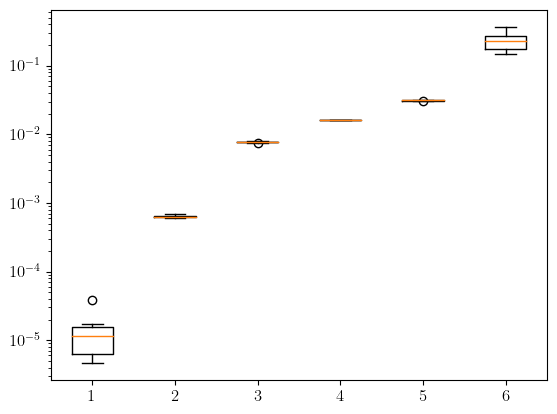

In [43]:
plt.figure()
plt.boxplot(boxes);
plt.yscale("log");

In [ ]:
plt.figure()
plt.boxplot(Q1);

In [ ]:
"""
Standardize data, handling the case when one column contains only same value (this happens in our case with vectors of only 0s).
"""
function standardize(x)
    std_ = std(x, dims=1)
    return (x .- mean(x, dims=1)) ./ ifelse.(std_ .> 0, std_, ones(size(std_)))
end


a = rand(10)

In [ ]:
standardize(a)

In [198]:
using PyPlot: @L_str, latexstring
using Printf

annot = Matrix{String}(undef, size(mean_value))
for i in eachindex(annot)
    foo = @sprintf("%.1e", mean_value[i])
    deci = split(foo, 'e')[1]
    power = parse(Int, split(foo, 'e')[2])
    power = string(power)
    annot[i] = latexstring(deci, "\\cdot 10^{", power, "}")
end

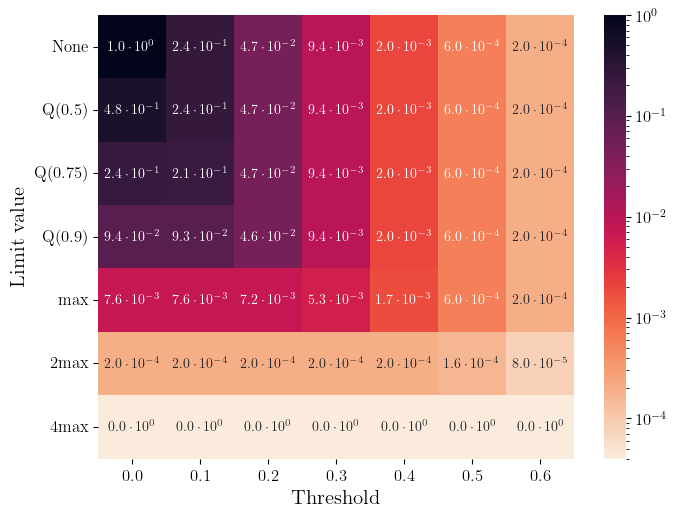

In [200]:
import Seaborn as sns

result = load_data("/Users/cyrilvallez/Desktop/Thesis/Results/Find_thresholds/new_test2_TE.jld2")
labels = ["None", "Q(0.5)", "Q(0.75)", "Q(0.9)", "max", "2max", "4max"]
thresholds = 0:0.1:0.6


mean_value = Matrix{Float64}(undef, size(result))
for i in eachindex(result)
    mean_value[i] = mean(result[i])
end

if any(mean_value .== 0)
    vmin = minimum(mean_value[mean_value .!= 0])*0.5
else
    vmin = minimum(mean_value)
end

plt.figure(figsize=[6.4, 4.8].*1.2)
sns.heatmap(mean_value, annot=annot, cmap="rocket_r", fmt="", norm=plt.matplotlib.colors.LogNorm(vmin=vmin, clip=true))
plt.xlabel("Threshold")
plt.ylabel("Limit value")
xloc, xlabels = plt.xticks()
plt.xticks(xloc, thresholds)
yloc, ylabels = plt.yticks()
plt.yticks(yloc, labels, rotation="horizontal")
plt.gcf();

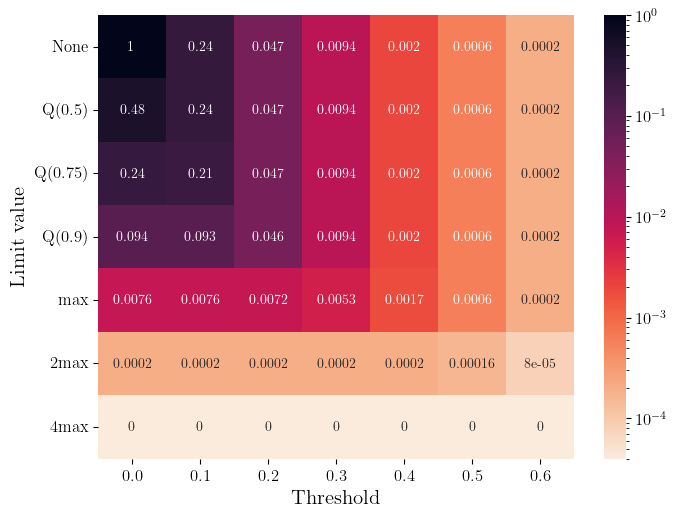

In [202]:
import Seaborn as sns

result = load_data("/Users/cyrilvallez/Desktop/Thesis/Results/Find_thresholds/new_test2_TE.jld2")
labels = ["None", "Q(0.5)", "Q(0.75)", "Q(0.9)", "max", "2max", "4max"]
thresholds = 0:0.1:0.6


mean_value = Matrix{Float64}(undef, size(result))
for i in eachindex(result)
    mean_value[i] = mean(result[i])
end

if any(mean_value .== 0)
    vmin = minimum(mean_value[mean_value .!= 0])*0.5
else
    vmin = minimum(mean_value)
end

plt.figure(figsize=[6.4, 4.8].*1.2)
sns.heatmap(mean_value, annot=true, cmap="rocket_r", fmt=".2g", norm=plt.matplotlib.colors.LogNorm(vmin=vmin, clip=true))
plt.xlabel("Threshold")
plt.ylabel("Limit value")
xloc, xlabels = plt.xticks()
plt.xticks(xloc, thresholds)
yloc, ylabels = plt.yticks()
plt.yticks(yloc, labels, rotation="horizontal")
plt.gcf();

In [9]:
df = load_dataset(Skripal)

,created_at,domain,username,follower_count
,String,Array…,String,Int64
1,2018-03-06T23:59:40.000Z,"[""twitter.com""]",lindhays,1176
2,2018-03-06T23:59:28.000Z,"[""theguardian.com""]",Tesscatbird,979
3,2018-03-06T23:59:01.000Z,"[""theguardian.com""]",crlulukat,440
4,2018-03-06T23:58:36.000Z,"[""nbcnews.com""]",tiffanyclay,2909
5,2018-03-06T23:58:22.000Z,"[""theguardian.com""]",KarCranky,242
6,2018-03-06T23:58:22.000Z,"[""theguardian.com""]",electricboyo,1573
7,2018-03-06T23:58:11.000Z,"[""nbcnews.com""]",rhscsmtms,1420
8,2018-03-06T23:57:59.000Z,"[""nbcnews.com""]",AJ_9342,138
9,2018-03-06T23:57:58.000Z,"[""theguardian.com""]",unitedMongrels,1303


In [10]:
using Dates
to_datetime = x -> DateTime(split(x, '.')[1], "yyyy-mm-ddTHH:MM:SS")
df."created_at" = to_datetime.(df."created_at")

630101-element Vector{DateTime}:
 2018-03-06T23:59:40
 2018-03-06T23:59:28
 2018-03-06T23:59:01
 2018-03-06T23:58:36
 2018-03-06T23:58:22
 2018-03-06T23:58:22
 2018-03-06T23:58:11
 2018-03-06T23:57:59
 2018-03-06T23:57:58
 2018-03-06T23:57:34
 2018-03-06T23:57:16
 2018-03-06T23:57:13
 2018-03-06T23:57:09
 ⋮
 2018-04-21T00:08:04
 2018-04-21T00:08:03
 2018-04-21T00:07:55
 2018-04-21T00:07:14
 2018-04-21T00:06:42
 2018-04-21T00:06:05
 2018-04-21T00:03:22
 2018-04-21T00:02:57
 2018-04-21T00:02:04
 2018-04-21T00:01:41
 2018-04-21T00:01:05
 2018-04-21T00:00:17

In [12]:
sort!(df, :follower_count, rev=true)

,created_at,domain,username,follower_count
,DateTime,Array…,String,Int64
1,2018-04-10T08:50:55,"[""cnn.com""]",cnnbrk,54691069
2,2018-04-10T08:47:05,"[""cnn.com""]",cnnbrk,54690835
3,2018-04-06T13:32:18,"[""cnn.com""]",cnnbrk,54646891
4,2018-03-28T20:49:37,"[""cnn.com""]",cnnbrk,54543668
5,2018-03-08T19:50:50,"[""cnn.com""]",cnnbrk,54321499
6,2018-03-07T18:15:56,"[""cnn.com""]",cnnbrk,54307069
7,2018-04-17T18:31:08,"[""nytimes.com""]",nytimes,41840651
8,2018-04-14T07:17:05,"[""nytimes.com""]",nytimes,41788883
9,2018-04-10T08:49:33,"[""nytimes.com""]",nytimes,41723015


In [17]:
minimum(df.created_at)

2018-03-01T14:15:34

In [18]:
maximum(df.created_at)

2018-04-29T23:57:41

In [26]:
decide = x -> x < Date(2018, 03, 18)

a = DateTime(2018, 03, 18, 00, 00, 01)
b = DateTime(2018, 03, 17, 23, 59, 59)
c = DateTime(2018, 03, 18, 00, 00, 00)

2018-03-18T00:00:00

In [27]:
decide(c)

false